In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


Use Latex Font

In [ ]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "axes.labelsize": 14,               # Font size for labels
    "font.size": 11,                    # General font size
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})

Use color friendly colors

In [ ]:
plt.style.use('tableau-colorblind10')

# Methodology

In [2]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

In [ ]:
df_combine = pd.read_csv('../../Data/time_series_1979-2023/combined_file_mec.csv',
                         index_col = 0,
                         parse_dates = True
                         )

,onshorewind_atlite,onshorewind_c3se_gridded,onshorewind_c3se_national,pv_atlite,pv_atlite_2030,pv_c3se_gridded,pv_c3se_gridded_2030,pv_c3se_national,combine_atlite_2023,combine_c3se_gridded_2023,combine_c3se_national_2023,combine_atlite_2030,combine_c3se_gridded_2030,combine_c3se_national_2030
1979-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_combine_avg = df_combine.rolling('D', min_periods=24, center=True).mean()


In [4]:
droughts_dict = {}

for column in df_combine_avg:
    raw_droughts = identify_drought(df_combine_avg[column], 0.15)
    droughts = raw_droughts[raw_droughts > 24]
    droughts_df = pd.DataFrame(droughts)
    droughts_df = droughts_df.set_axis(['Duration'], axis=1)
    droughts_dict[column] = droughts_df

In [5]:
df_flags = pd.DataFrame(index=df_combine_avg.index)

for col in df_combine_avg:
    series = df_combine_avg[col]
    new_series = pd.Series(0, index=series.index)
    count = 0
    for i in range(len(series)):
        if series.iloc[i] < 0.1:
            count += 1
        else:
            if count > 24:
                new_series.iloc[i-count:i] = 1
            count = 0
    if count > 24:
        new_series.iloc[len(series)-count:len(series)] = 1
    df_flags[col] = new_series

# Plots

## Change methodology 

In [6]:
# Define days in months
dim = np.array([31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# Define the order of the months for plotting
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [7]:
categories = {
    'onshorewind': ['onshorewind_atlite', 'onshorewind_c3se_gridded', 'onshorewind_c3se_national'],
    'pv': ['pv_atlite', 'pv_c3se_gridded', 'pv_c3se_national'],
    'combine_2023': ['combine_atlite_2023', 'combine_c3se_gridded_2023', 'combine_c3se_national_2023'],
    'combine_2030': ['combine_atlite_2030', 'combine_c3se_gridded_2030', 'combine_c3se_national_2030']
}

label_name = ['Atlite', 'C3S-E G', 'C3S-E N']
title_name = ['a) Wind', 'b) PV', 'c) Current', 'd) Projected']
color_models = ['#E24A33', '#348ABD', '#988ED5']

def my_title(ax, title):
    ax.set_title(title, x=0.5, y=0.945, transform=ax.transAxes, fontsize=16, 
                 bbox=dict(facecolor='white', alpha=1))

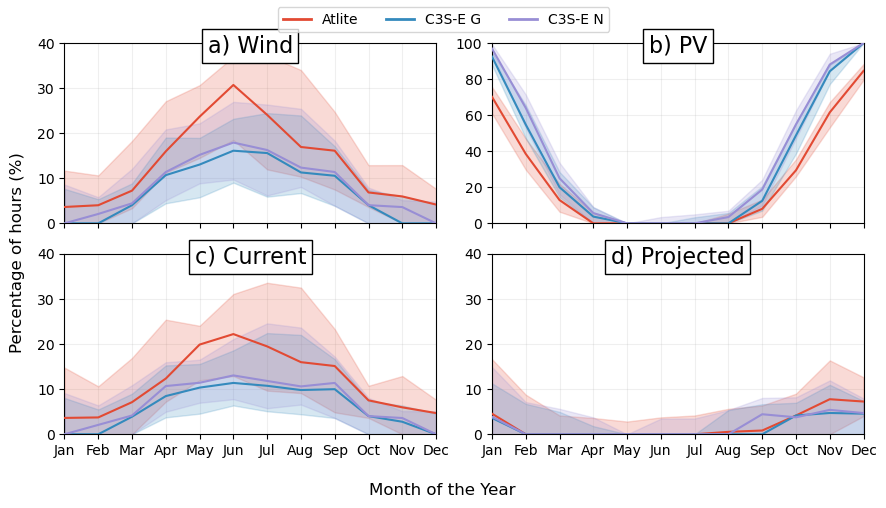

In [ ]:
fig, axs = plt.subplots(2, 2,
                        sharex=True,
                        # sharey=True,           
                        figsize=(9, 5)
)
axs = axs.flatten()

# Loop over categories
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]

    # Loop over datasets in category
    for i, name in enumerate(datasets_in_category):

        # Select data
        df = df_flags[name]

        # Calculate Annual reduction for Article and print
        mean_year = df.resample('Y').mean() * 100
        annual_median = mean_year.median()
        # print(name, annual_median)

        # Calculate 
        df_resam = df.resample('M').mean() * 100
        monthly_event_median = df_resam.groupby(df_resam.index.month).median() 
        monthly_event_q1 = df_resam.groupby(df_resam.index.month).quantile(0.25) 
        monthly_event_q3 = df_resam.groupby(df_resam.index.month).quantile(0.75) 

        # Plot bars
        ax.plot(months, monthly_event_median,
                # marker = 'o',
                color = color_models[i],
                zorder=3
        )
        ax.fill_between(months, monthly_event_q1, monthly_event_q3,
                color = color_models[i],
                zorder=2,
                alpha=0.2
        )

    my_title(ax, title_name[idx]) 
    ax.set_xlim(0,11)
    if idx == 1:
        ax.set_ylim(0,100)
    else:
        ax.set_ylim(0,40)
    ax.grid(True, alpha=0.2, zorder=0)

handles = [mlines.Line2D([], [], color=color_models[i], label=label_name[i], linewidth=2) for i in range(len(color_models))]
fig.legend(handles = handles, loc = 'upper center', ncol = 3, markerscale = 2)

fig.supxlabel('Month of the Year')
fig.supylabel('Percentage of hours (%)')
# fig.suptitle('Average days which are considered as event')
fig.tight_layout()
fig.subplots_adjust(top=0.92)
# fig.savefig('../Figures/droughts_seasonality.pdf', dpi=300)

Calculate Number in Article

In [14]:
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    for i, name in enumerate(datasets_in_category):
        print(name, df_flags[name].sum() / df_flags[name].shape)

onshorewind_atlite [0.15535258]
onshorewind_c3se_gridded [0.09348382]
onshorewind_c3se_national [0.1041616]
pv_atlite [0.26239403]
pv_c3se_gridded [0.35600714]
pv_c3se_national [0.38241259]
combine_atlite_2023 [0.13649408]
combine_c3se_gridded_2023 [0.08285167]
combine_c3se_national_2023 [0.09245964]
combine_atlite_2030 [0.0493353]
combine_c3se_gridded_2030 [0.03469518]
combine_c3se_national_2030 [0.04047264]
